In [ ]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations


# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype,RandomHorizontalFlip, RandomRotation


# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno
from collections import Counter

# metrics and evaluation
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

In [ ]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

        ##########################
    @staticmethod
    def make_lr_fn(start_lr,end_lr,num_iter,step_mode='exp'):
        '''
        step_mode: 'linear' or 'exp'
        '''
        if step_mode == 'linear':
            factor = (end_lr / start_lr -1) / num_iter
            def lr_fn(iteration):
                return 1 + iteration * factor
        else:
            factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
            def lr_fn(iteration):
                return np.exp(factor * iteration)
        return lr_fn
        ##########################

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = self.make_lr_fn(start_lr, end_lr, num_iter) # erro(precisa usar self.make_lr_fn,pois ela está decorada com @staticmethod)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

# Data Generation
## This dataset was pre-processed and filtered to classify 10 different sports:
* baseball, basketball, bmx, football, formula 1 racing, nascar racing, rugby, tennis, track bicycle, volleyball

In [ ]:
# Caminho do arquivo zip
arquivo_zip = '/content/imagem_sport_10_split.zip'

# Pasta onde o conteúdo será extraído
main_folder = '/content/imagem_sport'

# Pasta onde o conteúdo será extraído
temp_folder = '/content/imagem_sport/train'

classes_desejadas = ['baseball', 'basketball', 'bmx', 'football', 'formula 1 racing',
                     'nascar racing', 'rugby', 'tennis', 'track bicycle', 'volleyball']

# Criar a pasta de destino, caso não exista
os.makedirs(main_folder, exist_ok=True)

# Abrir o arquivo zip e extrair o conteúdo
with zipfile.ZipFile(arquivo_zip, 'r') as zip_ref:
    zip_ref.extractall(main_folder)

print("Extração concluída!")

Extração concluída!


In [ ]:
# feito a modificação na função de visualização da imagem para acomodar a quantidade de classes a serem trabalhadas.
def figure1(key_class:list, folder='rps'): # colocado classe não padrão primeiro para evitar ambiguidade
    images = []
    titles = []
    for class_name in key_class:
        path_img = os.path.join(folder, 'train', class_name, '002.jpg')
        if os.path.exists(path_img):
            images.append(Image.open(path_img))
            titles.append(class_name)
        else:
            print(f"Imagem não encontrada: {path_img}")
    # Cria subplots de acordo com a quantidade de imagens
    fig, axs = plt.subplots(1, len(images), figsize=(4 * len(images), 4), constrained_layout=True)
    if len(images) == 1:
      axs = [axs]

    for ax, img, title in zip(axs, images, titles):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)

    return fig


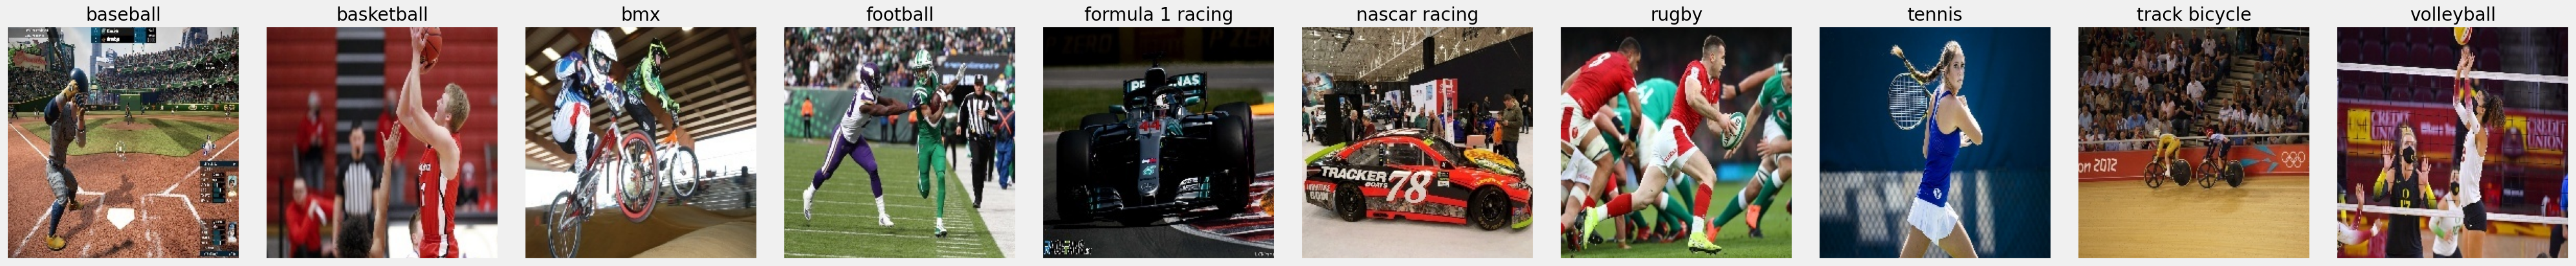

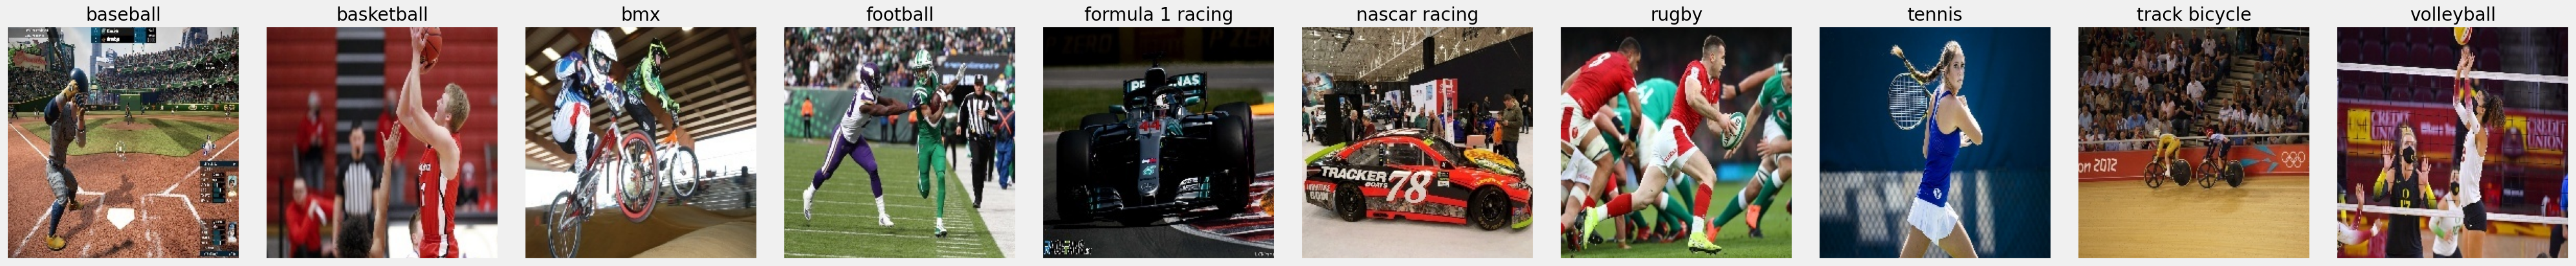

In [ ]:
figure1(classes_desejadas,main_folder)

# Data Preparation
## ImageFolder

In [ ]:
Architecture.set_seed(42) # garantir toda reprodutividade
# Compose a sequence of preprocessing transforms
# 1) Resize images to 28×28 pixels
# 2) Ensure output is a PIL/torchvision Image (dropping any alpha channel)
# 3) Convert pixel values to float32 and scale from [0–255] to [0.0–1.0]
temp_transform = Compose([
    Resize(28),                        # Resize each image to 28×28
    ToImage(),                         # Convert tensor back to PIL Image (enforces RGB)
    ToDtype(torch.float32, scale=True) # Cast to float32 and normalize pixel range
])

# Create an ImageFolder dataset from the 'rps' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
temp_dataset = ImageFolder(root= temp_folder,transform=temp_transform)

#Standardization
temp_loader = DataLoader(temp_dataset, batch_size=16,shuffle=False)

#Normalize
normalizer = Architecture.make_normalizer(temp_loader)

# to test,validation
composer = Compose([
    Resize(28),                         # Resize to 28×28
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer
])

# specific to training
composer_t = Compose([
    Resize(28),
    RandomHorizontalFlip(),
    RandomRotation(10),
    ToImage(),
    ToDtype(torch.float32, scale=True),
    normalizer
])

# Create an ImageFolder dataset from the 'main_folder' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
train_data = ImageFolder(root='/content/imagem_sport/train',transform=composer_t)
test_data = ImageFolder(root='/content/imagem_sport/test',transform=composer)
val_data = ImageFolder(root='/content/imagem_sport/val',transform=composer)


# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
# - no shuffle for test and validation
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader   = DataLoader(test_data,   batch_size=len(test_data))
val_loader   = DataLoader(val_data,   batch_size=16)





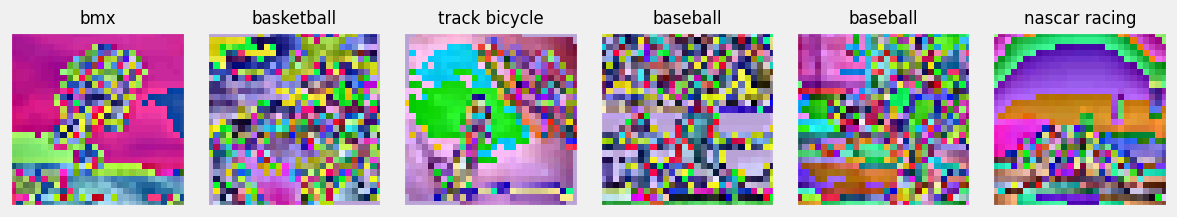

In [ ]:
def figure2(first_images, first_labels):
    fig, axs = plt.subplots(1, 6, figsize=(12, 4))
    titles = classes_desejadas
    for i in range(6):
        image, label = ToPILImage()(first_images[i]), first_labels[i]
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)
    fig.tight_layout()
    return fig

torch.manual_seed(42)
first_images, first_labels = next(iter(train_loader))
fig = figure2(first_images, first_labels)

# Model Architectures

In [ ]:
# base model
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 10)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (10)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [ ]:
# base model  + hyperparameters (increase the extracted features)
class CNN2_M2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2_M2,self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels= n_feature,
                               kernel_size=3)
        # Creates the linear layers
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 10)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (10)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [ ]:
# base model + block
class CNN2_M3(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2_M3,self).__init__()
        self.n_feature = n_feature
        self.p = p

        # Creates the linear layers
        # Blocos de convolução + maxpool
        # Camadas de convolução mantém o tamanho da imagem 28x28 → 28x28
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)


        # Creates the linear layers
        self.fc1 = nn.Linear(n_feature * 6 * 6, 50)
        self.fc2 = nn.Linear(50, 10)

        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        x = F.relu(self.conv1(x))        # 3×28×28 → n×28×28
        x = F.max_pool2d(x, kernel_size=2) # 3×28×28 → n×14×14
        x = F.relu(self.conv2(x))        # n×14×14 → n×14×14
        x = F.relu(self.conv3(x))        # n×14×14 → n×12×12
        x = F.max_pool2d(x, kernel_size=2)
        x = nn.Flatten()(x)              # → n×(n_feature * 6 * 6)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 6 * 6)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (10)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [ ]:
# exclusive model
class CNN2_M4(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2_M4,self).__init__()
        self.n_feature = n_feature
        self.p = p

        # Creates the linear layers
        # Blocos de convolução + maxpool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)   # 28x28 → nx26x26
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)

        # Creates the linear layers
        self.fc1 = nn.Linear(n_feature * 6 * 6, 50)
        self.fc2 = nn.Linear(50, 10)


        # Creates dropout layers
        self.drop = nn.Dropout(self.p)



    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        x = F.relu(self.conv1(x))        # 3×28×28 → n×26×26
        x = F.relu(self.conv2(x))        # n×26×26 → n×26×26
        x = F.relu(self.conv3(x))        # n×26×26 → n×24×24
        x = F.max_pool2d(x, kernel_size=2) #n×24×24→ n×12×12
        x = F.max_pool2d(x, kernel_size=2) #n×24×24→ n×12×12

        x = nn.Flatten()(x)              # → 3×(32 * 12 * 12)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x


    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Setting up the models
* We created four different models,
* a weight-balanced loss function and an optimizer.
* The models will be an instance of our CNN2 class with variations in features and convolution and pooling layer placement, and a 50% dropout probability.
* Our dataset has ten classes, so we're using nn.CrossEntropyLoss() (which will receive the 10 logits produced by the model).
* Calculates the weights for the loss function
* applies weight_decay


In [ ]:
# Creating a weight tensor to Loss function
labels = [label for _, label in train_data]

# count samples by class
num_classes = len(set(labels))
class_counts = Counter(labels)
total_samples = sum(class_counts.values())

# Calculates weights inversely proportional to frequency
class_weights = [0] * num_classes
for cls in range(num_classes):
    class_weights[cls] = total_samples / (num_classes * class_counts[cls])

# Converts to tensor and sends to the same device as the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pesos_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)



# Model/Architecture
model_cnn = CNN2(n_feature=16, p=0.5)
model_cnn_nf = CNN2_M2(n_feature=32, p=0.5)
model_cnn_b = CNN2_M3(n_feature=32, p=0.5)
model_cnn_ex = CNN2_M4(n_feature=32, p=0.5)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean',weight=pesos_tensor)

# Optimizer
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=3e-4,weight_decay=1e-4)
optimizer_cnn_nf = optim.Adam(model_cnn_nf.parameters(), lr=3e-4,weight_decay=1e-4)
optimizer_cnn_b = optim.Adam(model_cnn_b.parameters(), lr=2e-4,weight_decay=1e-4)
optimizer_cnn_ex = optim.Adam(model_cnn_ex.parameters(), lr=2e-4,weight_decay=1e-4)

In [ ]:
pesos_tensor

tensor([0.9414, 0.9640, 1.1476, 0.8607, 0.8607, 0.8669, 0.9797, 1.2296, 1.1931,
        1.1368])

# Training models

In [ ]:
# modelo base
arch_cnn = Architecture(model_cnn,multi_loss_fn,optimizer_cnn)
arch_cnn.to('cuda')
arch_cnn.set_loaders(train_loader, val_loader)
arch_cnn.train(100)

# Accuracy
results = Architecture.loader_apply(val_loader, arch_cnn.correct)
print('hits by class:',results)
print('total hits:', Architecture.loader_apply(val_loader,arch_cnn.correct).sum(axis=0))
print('Accuracy:',(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,arch_cnn.correct).sum(axis=0)))


Couldn't send it to cuda, sending it to cpu instead.
hits by class: tensor([[ 8, 28],
        [13, 27],
        [11, 22],
        [ 7, 30],
        [23, 30],
        [13, 30],
        [17, 26],
        [14, 21],
        [17, 22],
        [13, 23]])
total hits: tensor([136, 259])
Accuracy: 0.525096525096525


In [ ]:
# n_feature model
arch_cnn_nf = Architecture(model_cnn_nf,multi_loss_fn,optimizer_cnn_nf)
arch_cnn_nf.to('cuda')
arch_cnn_nf.set_loaders(train_loader, val_loader)
arch_cnn_nf.train(100)

# Accuracy
results = Architecture.loader_apply(val_loader, arch_cnn_nf.correct)
print('hits by class:',results)
print('total hits:', Architecture.loader_apply(val_loader,arch_cnn_nf.correct).sum(axis=0))
print('Accuracy:',(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,arch_cnn_nf.correct).sum(axis=0)))

Couldn't send it to cuda, sending it to cpu instead.
hits by class: tensor([[11, 28],
        [15, 27],
        [ 7, 22],
        [12, 30],
        [22, 30],
        [20, 30],
        [14, 26],
        [14, 21],
        [19, 22],
        [15, 23]])
total hits: tensor([149, 259])
Accuracy: 0.5752895752895753


In [ ]:
# modelo bloco
arch_cnn_b = Architecture(model_cnn_b,multi_loss_fn,optimizer_cnn_b)
arch_cnn_b.to('cuda')
arch_cnn_b.set_loaders(train_loader, val_loader)
arch_cnn_b.train(100)

# Accuracy
results = Architecture.loader_apply(val_loader, arch_cnn_b.correct)
print('hits by class:',results)
print('total hits:', Architecture.loader_apply(val_loader,arch_cnn_b.correct).sum(axis=0))
print('Accuracy:',(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,arch_cnn_b.correct).sum(axis=0)))

Couldn't send it to cuda, sending it to cpu instead.
hits by class: tensor([[12, 28],
        [16, 27],
        [12, 22],
        [13, 30],
        [23, 30],
        [12, 30],
        [17, 26],
        [14, 21],
        [18, 22],
        [15, 23]])
total hits: tensor([152, 259])
Accuracy: 0.5868725868725869


In [ ]:
# modelo exclusivo
arch_cnn_ex = Architecture(model_cnn_ex,multi_loss_fn,optimizer_cnn_ex)
arch_cnn_ex.to('cuda')
arch_cnn_ex.set_loaders(train_loader, val_loader)
arch_cnn_ex.train(100)

# Accuracy
results = Architecture.loader_apply(val_loader, arch_cnn_ex.correct)
print('hits by class:',results)
print('total hits:', Architecture.loader_apply(val_loader,arch_cnn_ex.correct).sum(axis=0))
print('Accuracy:',(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,arch_cnn_ex.correct).sum(axis=0)))

Couldn't send it to cuda, sending it to cpu instead.
hits by class: tensor([[11, 28],
        [17, 27],
        [ 7, 22],
        [10, 30],
        [19, 30],
        [13, 30],
        [13, 26],
        [11, 21],
        [18, 22],
        [16, 23]])
total hits: tensor([135, 259])
Accuracy: 0.5212355212355212


In [ ]:
arch_cnn.save_checkpoint('parameters_cnn.pth')

In [ ]:
arch_cnn_nf.save_checkpoint('parameters_cnn_nf.pth')

In [ ]:
arch_cnn_b.save_checkpoint('parameters_cnn_b.pth')

In [ ]:
arch_cnn_ex.save_checkpoint('parameters_cnn_ex.pth')

#Hooks

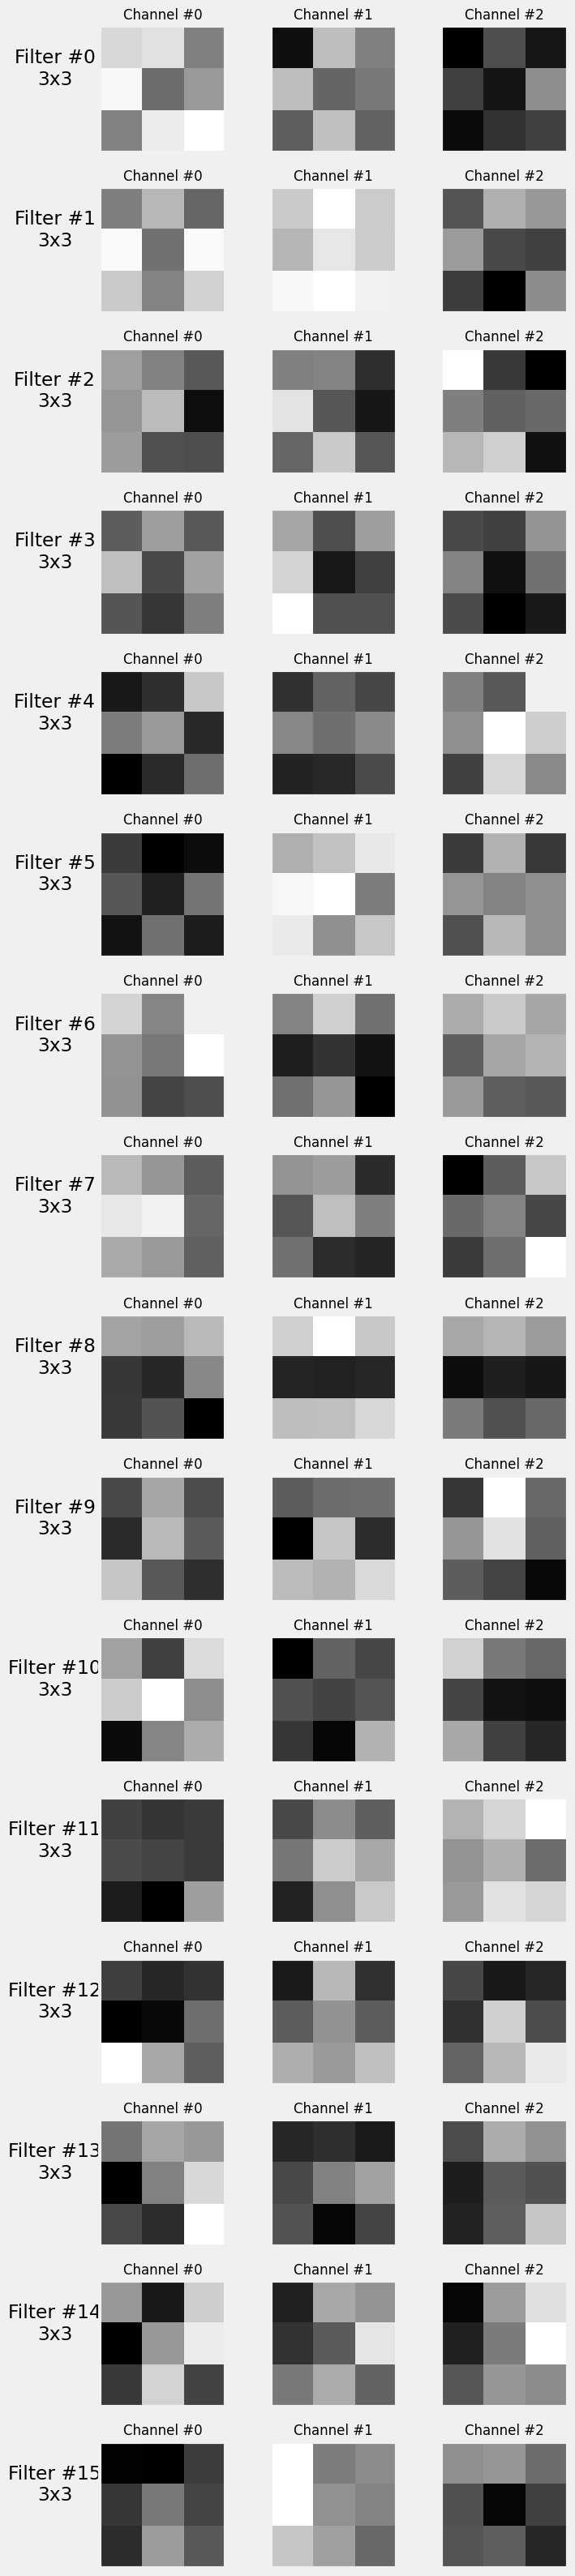

In [ ]:
fig_cnn = arch_cnn.visualize_filters('conv1')


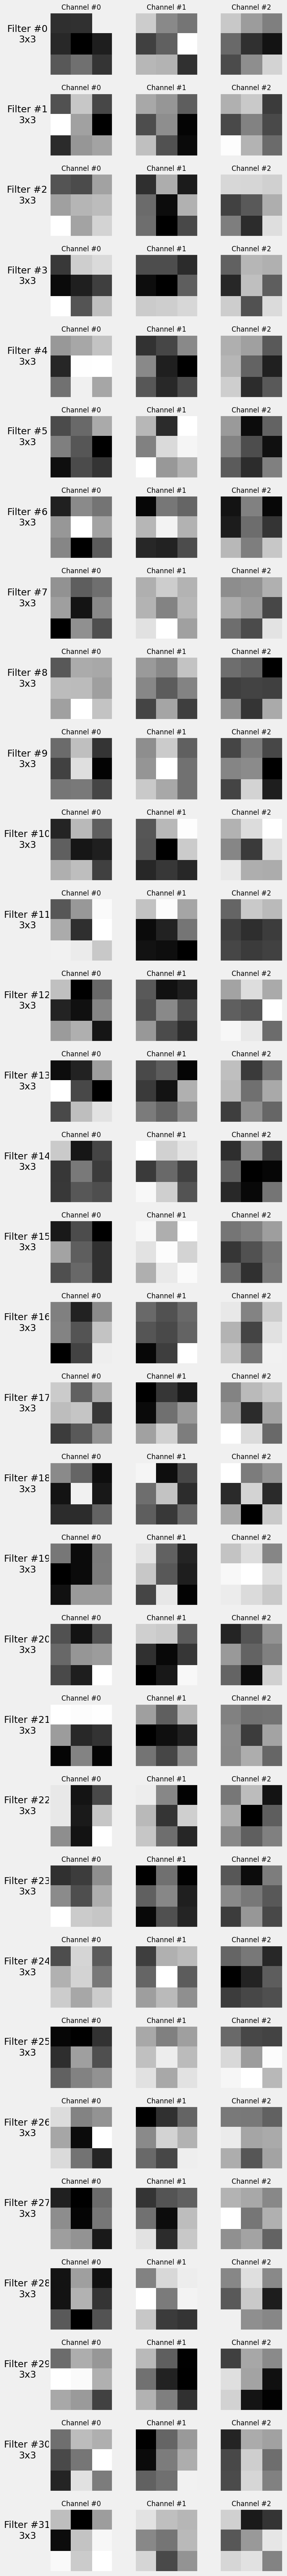

In [ ]:
fig_cnn_ex= arch_cnn_nf.visualize_filters('conv1')

# Model analysis

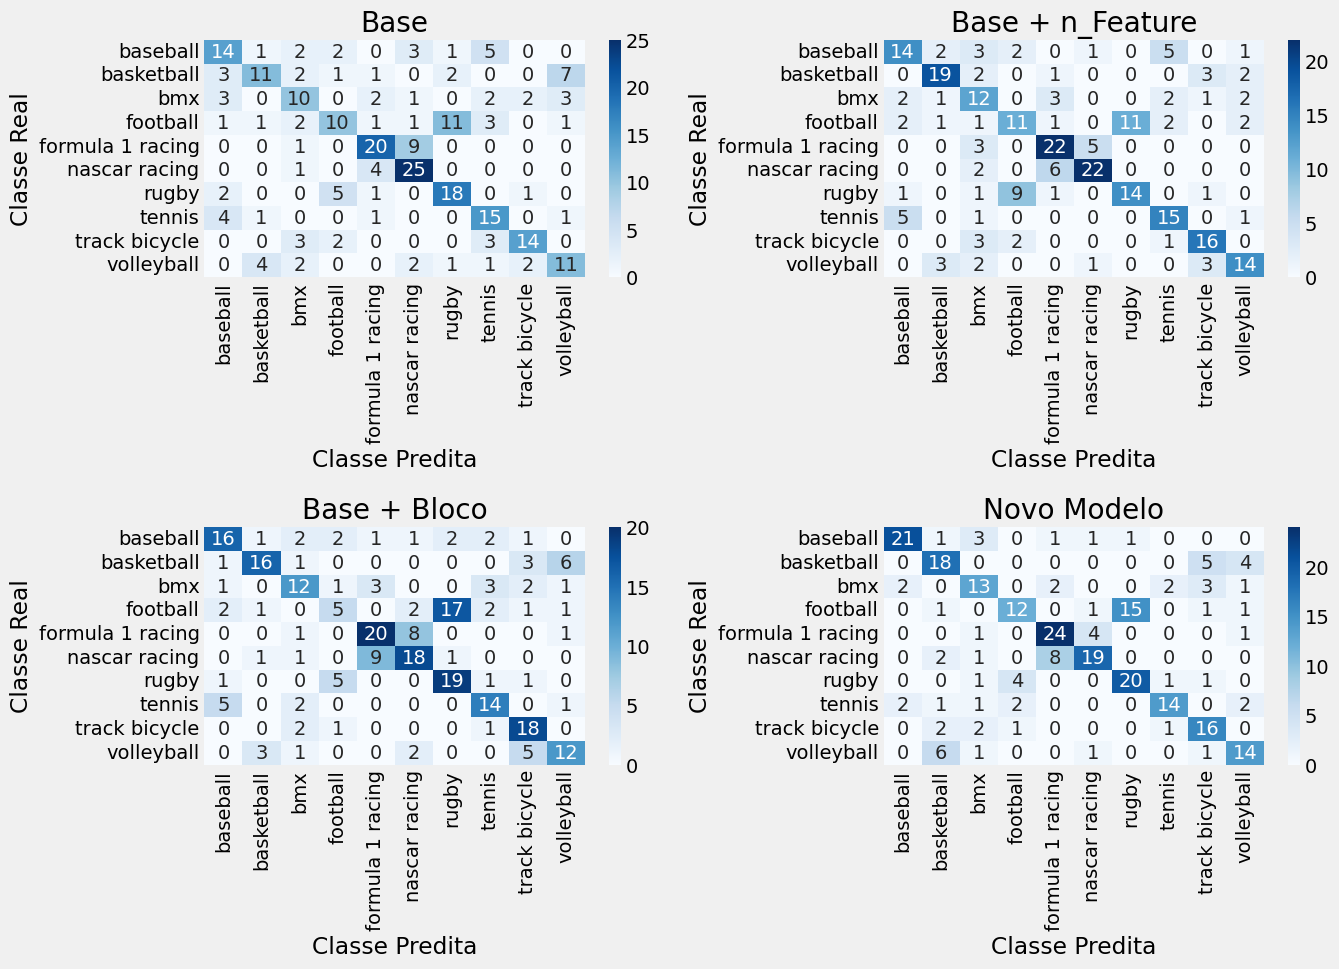

In [ ]:
# Pega o batch do test_loader
x_batch, y_batch = next(iter(test_loader))

# Faz a predição
yhat_cnn = arch_cnn.predict(x_batch)
yhat_cnn_nf = arch_cnn_nf.predict(x_batch)
yhat_cnn_b = arch_cnn_b.predict(x_batch)
yhat_cnn_ex = arch_cnn_ex.predict(x_batch)

# Transforma yhat (logits) em classe prevista (índice da maior probabilidade)
y_pred_cnn = torch.tensor(yhat_cnn).argmax(dim=1)
y_pred_cnn_nf = torch.tensor(yhat_cnn_nf).argmax(dim=1)
y_pred_cnn_b = torch.tensor(yhat_cnn_b).argmax(dim=1)
y_pred_cnn_ex = torch.tensor(yhat_cnn_ex).argmax(dim=1)

# Calcula a matriz de confusão para esse batch
matriz_cnn = confusion_matrix(y_batch.numpy(), y_pred_cnn.numpy())
matriz_nf = confusion_matrix(y_batch.numpy(), y_pred_cnn_nf.numpy())
matriz_b = confusion_matrix(y_batch.numpy(), y_pred_cnn_b.numpy())
matriz_ex = confusion_matrix(y_batch.numpy(), y_pred_cnn_ex.numpy())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

matrizes = [matriz_cnn, matriz_nf, matriz_b, matriz_ex]
titulos = ['Base', 'Base + n_Feature', 'Base + Bloco', 'Novo Modelo']

for ax, matriz, titulo in zip(axes.flat, matrizes, titulos):
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_data.classes,
                yticklabels=train_data.classes,
                ax=ax)
    ax.set_title(f'{titulo}')
    ax.set_xlabel('Classe Predita')
    ax.set_ylabel('Classe Real')

plt.tight_layout(pad=1.3)
plt.show()


In [ ]:
print(classification_report(y_batch.numpy(), y_pred_cnn.numpy()))

              precision    recall  f1-score   support

           0       0.67      0.36      0.47        28
           1       0.67      0.59      0.63        27
           2       0.58      0.61      0.60        23
           3       0.43      0.19      0.27        31
           4       0.66      0.77      0.71        30
           5       0.68      0.70      0.69        30
           6       0.48      0.78      0.59        27
           7       0.52      0.59      0.55        22
           8       0.47      0.68      0.56        22
           9       0.47      0.39      0.43        23

    accuracy                           0.56       263
   macro avg       0.56      0.57      0.55       263
weighted avg       0.57      0.56      0.55       263



In [ ]:
print(classification_report(y_batch.numpy(), y_pred_cnn_nf.numpy()))

              precision    recall  f1-score   support

           0       0.77      0.61      0.68        28
           1       0.71      0.56      0.62        27
           2       0.46      0.52      0.49        23
           3       0.42      0.32      0.36        31
           4       0.74      0.67      0.70        30
           5       0.69      0.83      0.76        30
           6       0.46      0.67      0.55        27
           7       0.80      0.73      0.76        22
           8       0.58      0.82      0.68        22
           9       0.59      0.43      0.50        23

    accuracy                           0.61       263
   macro avg       0.62      0.62      0.61       263
weighted avg       0.62      0.61      0.61       263



In [ ]:
print(classification_report(y_batch.numpy(), y_pred_cnn_b.numpy()))

              precision    recall  f1-score   support

           0       0.82      0.50      0.62        28
           1       0.63      0.63      0.63        27
           2       0.63      0.52      0.57        23
           3       0.45      0.29      0.35        31
           4       0.65      0.73      0.69        30
           5       0.68      0.70      0.69        30
           6       0.51      0.81      0.63        27
           7       0.83      0.68      0.75        22
           8       0.68      0.77      0.72        22
           9       0.48      0.61      0.54        23

    accuracy                           0.62       263
   macro avg       0.64      0.63      0.62       263
weighted avg       0.63      0.62      0.61       263



In [ ]:
print(classification_report(y_batch.numpy(), y_pred_cnn_ex.numpy()))

              precision    recall  f1-score   support

           0       0.67      0.57      0.62        28
           1       0.69      0.67      0.68        27
           2       0.57      0.52      0.55        23
           3       0.53      0.32      0.40        31
           4       0.69      0.67      0.68        30
           5       0.70      0.77      0.73        30
           6       0.59      0.70      0.64        27
           7       0.62      0.73      0.67        22
           8       0.68      0.86      0.76        22
           9       0.56      0.61      0.58        23

    accuracy                           0.63       263
   macro avg       0.63      0.64      0.63       263
weighted avg       0.63      0.63      0.63       263



In [ ]:
acc_cnn_no = round((lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(test_loader,arch_cnn.correct).sum(axis=0))* 100, 2)
acc_nf_no = round((lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(test_loader,arch_cnn_nf.correct).sum(axis=0))* 100, 2)
acc_b_no = round((lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(test_loader,arch_cnn_b.correct).sum(axis=0))* 100, 2)
acc_ex_no = round((lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(test_loader,arch_cnn_ex.correct).sum(axis=0))* 100, 2)

In [ ]:
lr_dict = {
    'Model': ['CNN', 'CNN_NF', 'CNN_B', 'CNN_EX'],
    'No_FindingLR': [3e-4, 3e-4, 2e-4, 2e-4],
    'Accuracy_NoFindingLR (%)': [acc_cnn_no, acc_nf_no, acc_b_no, acc_ex_no],
}

lr_df = pd.DataFrame(lr_dict)
lr_df

Model  No_FindingLR  Accuracy_NoFindingLR (%)
0     CNN        0.0003                     56.27
1  CNN_NF        0.0003                     61.22
2   CNN_B        0.0002                     61.98
3  CNN_EX        0.0002                     63.50

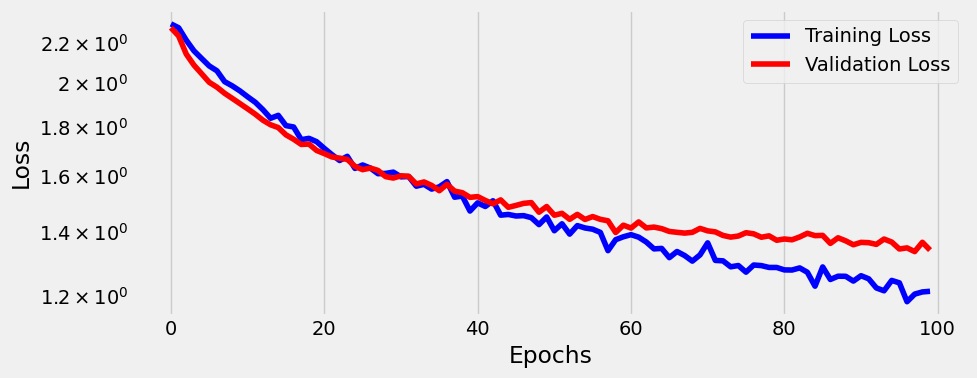

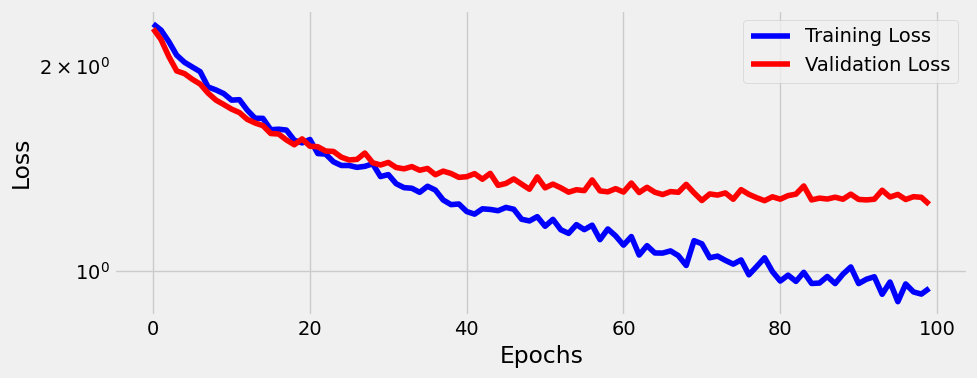

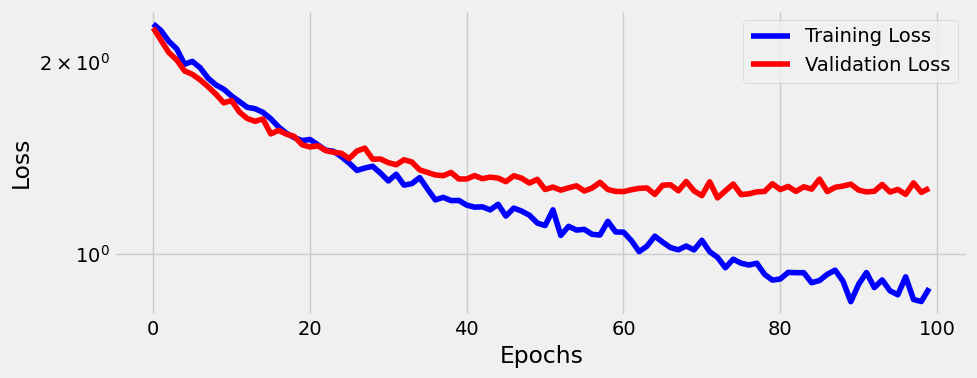

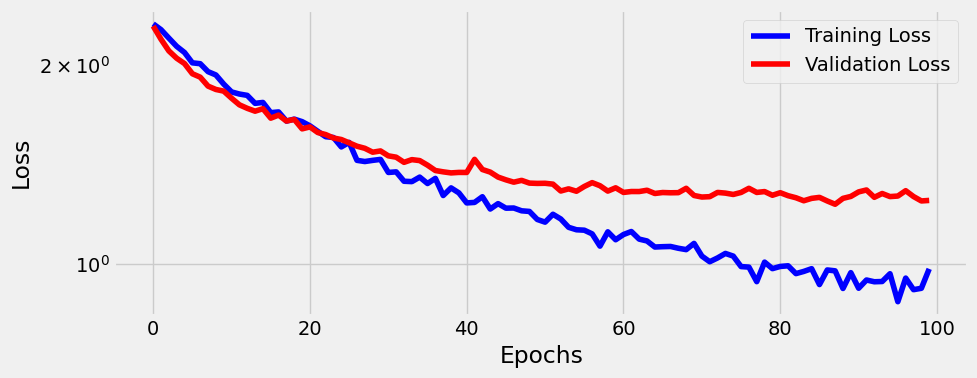

In [ ]:
fig1 = arch_cnn.plot_losses()
fig2 = arch_cnn_nf.plot_losses()
fig3 = arch_cnn_b.plot_losses()
fig4 = arch_cnn_ex.plot_losses()

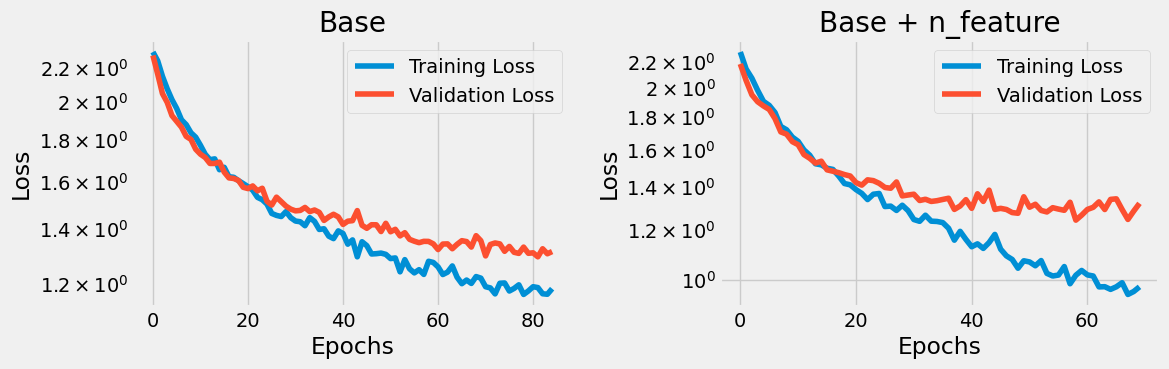

In [ ]:
# comparativo de perdas
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for ax in fig1.axes:
    for line in ax.get_lines():
        axs[0].plot(line.get_xdata(), line.get_ydata(), label=line.get_label())
    axs[0].set_title("Base")
    axs[0].set_yscale('log')
    axs[0].legend()
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

for ax in fig2.axes:
    for line in ax.get_lines():
        axs[1].plot(line.get_xdata(), line.get_ydata(), label=line.get_label())
    axs[1].set_title("Base + n_feature")
    axs[1].set_yscale('log')
    axs[1].legend()
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')

plt.tight_layout(pad=1.3)
plt.show()

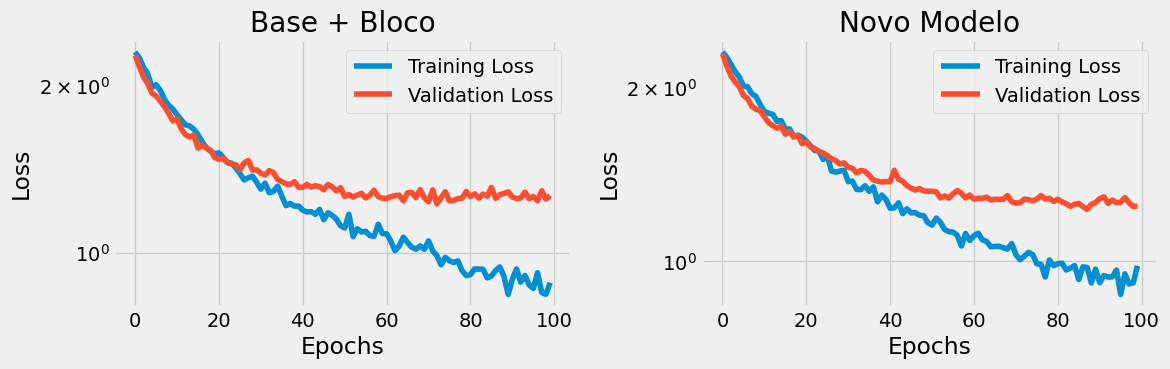

In [ ]:
# comparativo de perdas
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for ax in fig3.axes:
    for line in ax.get_lines():
        axs[0].plot(line.get_xdata(), line.get_ydata(), label=line.get_label())
    axs[0].set_title("Base + Bloco")
    axs[0].set_yscale('log')
    axs[0].legend()
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

for ax in fig4.axes:
    for line in ax.get_lines():
        axs[1].plot(line.get_xdata(), line.get_ydata(), label=line.get_label())
    axs[1].set_title("Novo Modelo")
    axs[1].set_yscale('log')
    axs[1].legend()
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')

plt.tight_layout(pad=1.3)
plt.show()

# Treinamento usando Finding LR
* Cyclical Learning Rates (CLR) de Leslie Smith

Couldn't send it to cuda, sending it to cpu instead.
Couldn't send it to cuda, sending it to cpu instead.
Couldn't send it to cuda, sending it to cpu instead.
Couldn't send it to cuda, sending it to cpu instead.


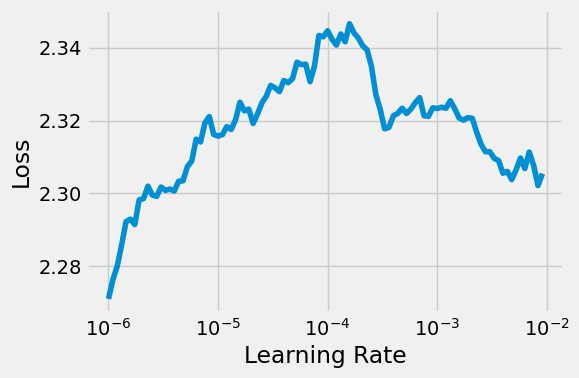

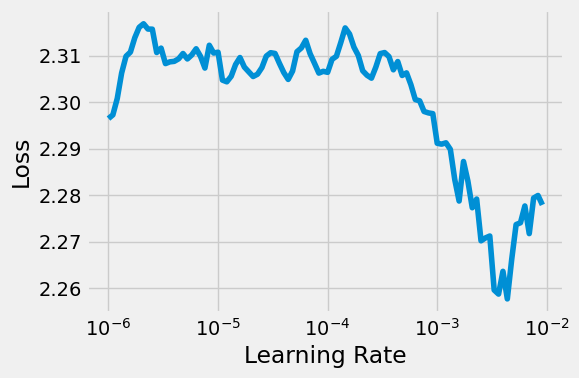

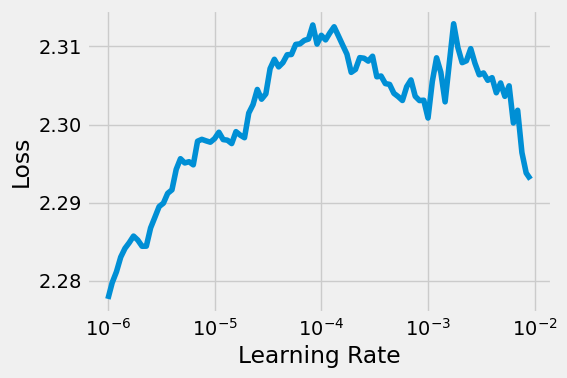

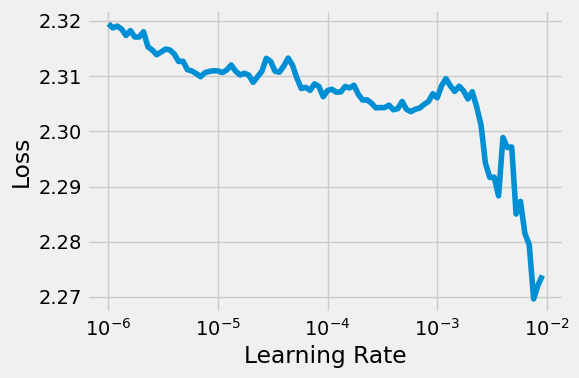

In [ ]:
Architecture.set_seed(42)
# Model/Architecture
model_cnn = CNN2(n_feature=16,p=0.5)
model_cnn_nf = CNN2_M2(n_feature=32,p=0.5)
model_cnn_b = CNN2_M3(n_feature=32,p=0.5)
model_cnn_ex = CNN2_M4(n_feature=32,p=0.5)

# Optimizer
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=1e-6, weight_decay=1e-4)
optimizer_cnn_nf = optim.Adam(model_cnn_nf.parameters(), lr=1e-6, weight_decay=1e-4)
optimizer_cnn_b = optim.Adam(model_cnn_b.parameters(), lr=1e-6, weight_decay=1e-4)
optimizer_cnn_ex = optim.Adam(model_cnn_ex.parameters(), lr=1e-6, weight_decay=1e-4)

#Architectures
arch_cnn = Architecture(model_cnn,multi_loss_fn,optimizer_cnn)
arch_cnn.to('cuda')

#cnn_nf
arch_cnn_nf = Architecture(model_cnn_nf,multi_loss_fn,optimizer_cnn_nf)
arch_cnn_nf.to('cuda')

#cnn_b
arch_cnn_b = Architecture(model_cnn_b,multi_loss_fn,optimizer_cnn_b)
arch_cnn_b.to('cuda')

#cnn_ex
arch_cnn_ex = Architecture(model_cnn_ex,multi_loss_fn,optimizer_cnn_ex)
arch_cnn_ex.to('cuda')

#Best_lr
tracking_cnn, _ = arch_cnn.lr_range_test(train_loader,0.01,num_iter=100,step_mode='exp')
tracking_cnn_nf, _ = arch_cnn_nf.lr_range_test(train_loader,0.01,num_iter=100,step_mode='exp')
tracking_cnn_b, _ = arch_cnn_b.lr_range_test(train_loader,0.01,num_iter=100,step_mode='exp')
tracking_cnn_ex, _ = arch_cnn_ex.lr_range_test(train_loader,0.01,num_iter=100,step_mode='exp')



In [ ]:
# Creating new optimizer with better LR
new_optimizer = optim.Adam(model_cnn.parameters(), lr=5e-4, weight_decay=1e-4) #5e-4
arch_cnn.set_optimizer(new_optimizer)

new_optimizer_nf = optim.Adam(model_cnn_nf.parameters(), lr=4.5e-4, weight_decay=1e-4)#3e-4
arch_cnn_nf.set_optimizer(new_optimizer_nf)

new_optimizer_b = optim.Adam(model_cnn_b.parameters(), lr=1.5e-4, weight_decay=1e-4) #2e-4,
arch_cnn_b.set_optimizer(new_optimizer_b)

new_optimizer_ex = optim.Adam(model_cnn_ex.parameters(), lr=5.4e-4, weight_decay=1e-4)#2e-4
arch_cnn_ex.set_optimizer(new_optimizer_ex)

#loader
#train

arch_cnn.set_loaders(train_loader, val_loader)
arch_cnn.train(85)

arch_cnn_nf.set_loaders(train_loader, val_loader)
arch_cnn_nf.train(70)

arch_cnn_b.set_loaders(train_loader, val_loader)
arch_cnn_b.train(100)

arch_cnn_ex.set_loaders(train_loader, val_loader)
arch_cnn_ex.train(65)


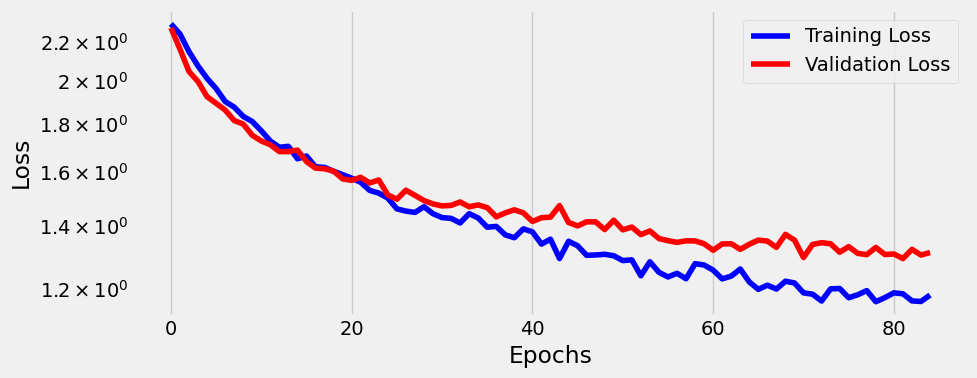

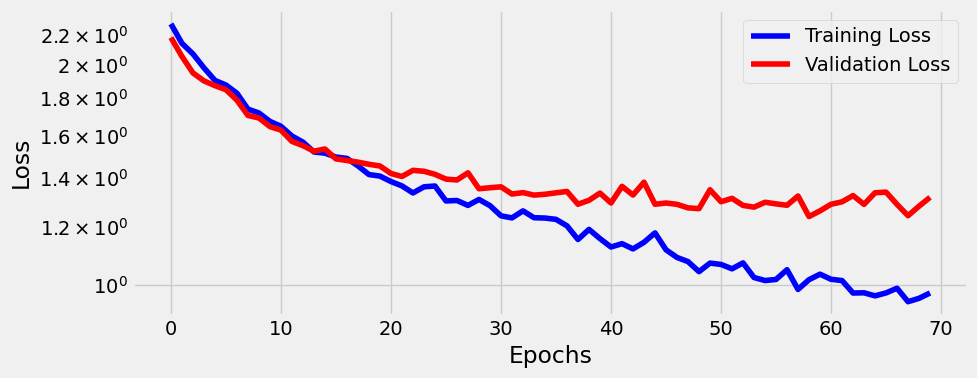

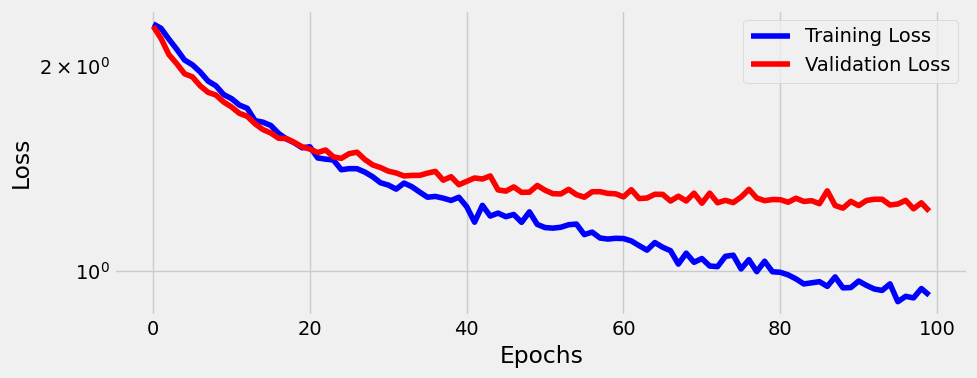

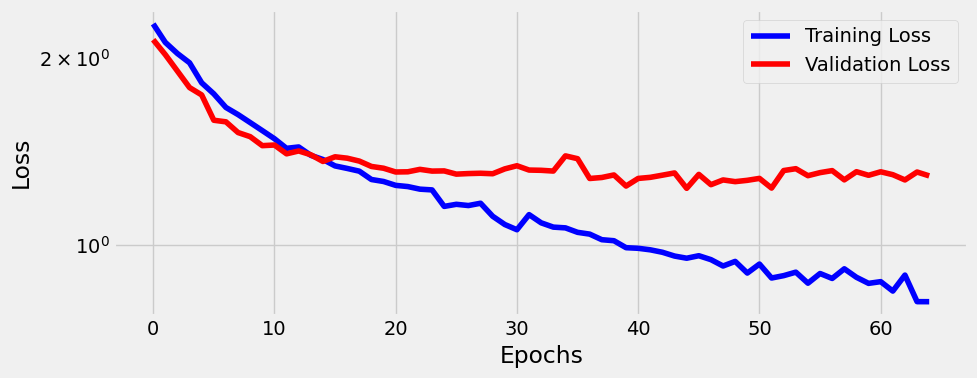

In [ ]:
fig1 = arch_cnn.plot_losses()
fig2 = arch_cnn_nf.plot_losses()
fig3 = arch_cnn_b.plot_losses()
fig4 = arch_cnn_ex.plot_losses()

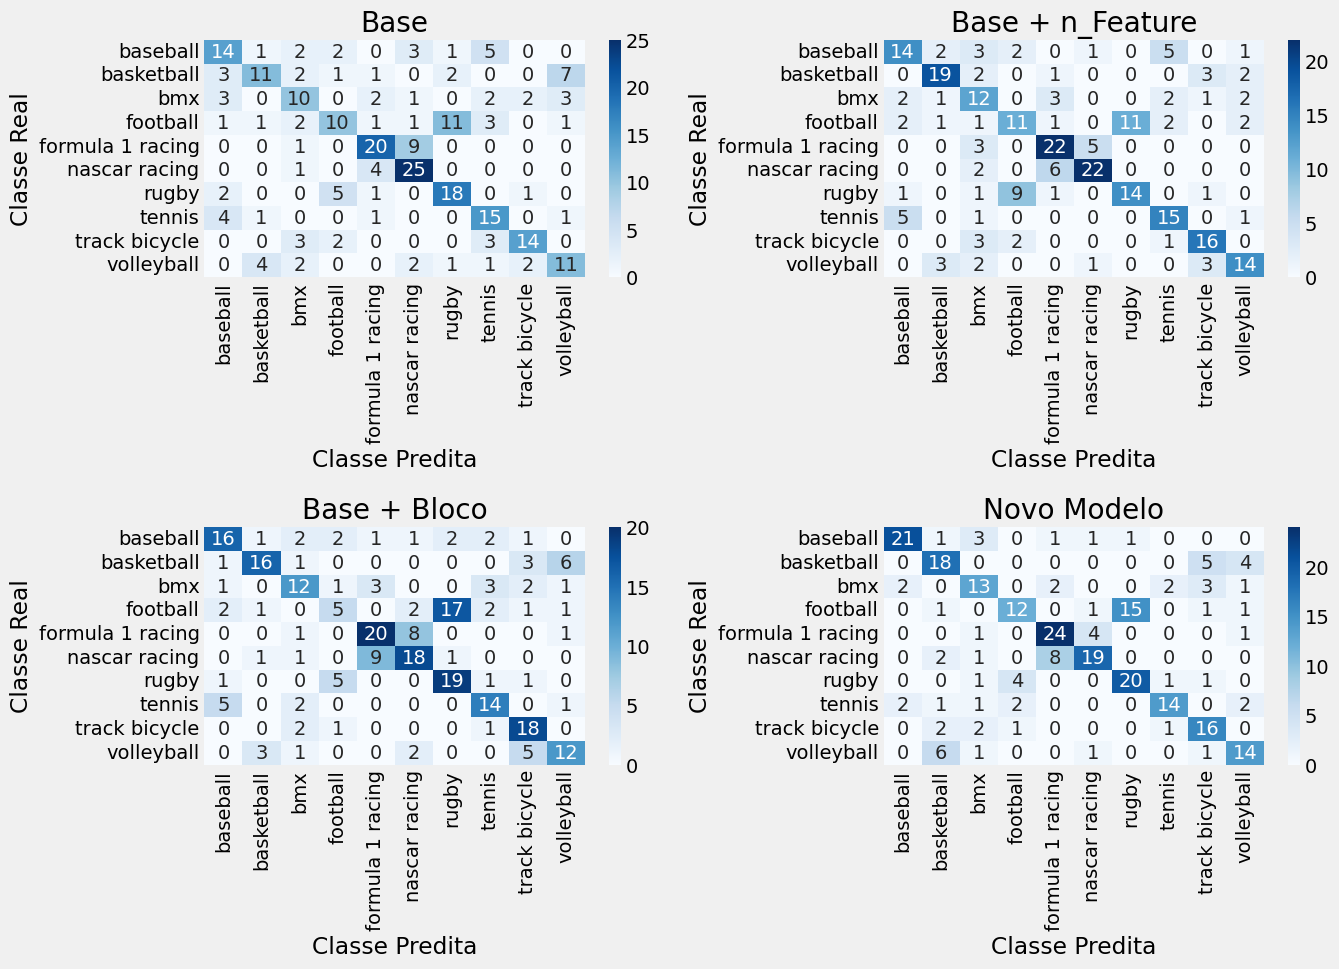

In [ ]:
# Pega o batch do test_loader
x_batch, y_batch = next(iter(test_loader))

# Faz a predição
yhat_cnn = arch_cnn.predict(x_batch)
yhat_cnn_nf = arch_cnn_nf.predict(x_batch)
yhat_cnn_b = arch_cnn_b.predict(x_batch)
yhat_cnn_ex = arch_cnn_ex.predict(x_batch)

# Transforma yhat (logits) em classe prevista (índice da maior probabilidade)
y_pred_cnn = torch.tensor(yhat_cnn).argmax(dim=1)
y_pred_cnn_nf = torch.tensor(yhat_cnn_nf).argmax(dim=1)
y_pred_cnn_b = torch.tensor(yhat_cnn_b).argmax(dim=1)
y_pred_cnn_ex = torch.tensor(yhat_cnn_ex).argmax(dim=1)

# Calcula a matriz de confusão para esse batch
matriz_cnn = confusion_matrix(y_batch.numpy(), y_pred_cnn.numpy())
matriz_nf = confusion_matrix(y_batch.numpy(), y_pred_cnn_nf.numpy())
matriz_b = confusion_matrix(y_batch.numpy(), y_pred_cnn_b.numpy())
matriz_ex = confusion_matrix(y_batch.numpy(), y_pred_cnn_ex.numpy())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

matrizes = [matriz_cnn, matriz_nf, matriz_b, matriz_ex]
titulos = ['Base', 'Base + n_Feature', 'Base + Bloco', 'Novo Modelo']

for ax, matriz, titulo in zip(axes.flat, matrizes, titulos):
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_data.classes,
                yticklabels=train_data.classes,
                ax=ax)
    ax.set_title(f'{titulo}')
    ax.set_xlabel('Classe Predita')
    ax.set_ylabel('Classe Real')

plt.tight_layout(pad=1.3)
plt.show()


In [ ]:
print(classification_report(y_batch.numpy(), y_pred_cnn.numpy()))

              precision    recall  f1-score   support

           0       0.52      0.50      0.51        28
           1       0.61      0.41      0.49        27
           2       0.43      0.43      0.43        23
           3       0.50      0.32      0.39        31
           4       0.67      0.67      0.67        30
           5       0.61      0.83      0.70        30
           6       0.55      0.67      0.60        27
           7       0.52      0.68      0.59        22
           8       0.74      0.64      0.68        22
           9       0.48      0.48      0.48        23

    accuracy                           0.56       263
   macro avg       0.56      0.56      0.55       263
weighted avg       0.56      0.56      0.55       263



In [ ]:
print(classification_report(y_batch.numpy(), y_pred_cnn_nf.numpy()))

              precision    recall  f1-score   support

           0       0.58      0.50      0.54        28
           1       0.73      0.70      0.72        27
           2       0.40      0.52      0.45        23
           3       0.46      0.35      0.40        31
           4       0.65      0.73      0.69        30
           5       0.76      0.73      0.75        30
           6       0.56      0.52      0.54        27
           7       0.60      0.68      0.64        22
           8       0.67      0.73      0.70        22
           9       0.64      0.61      0.62        23

    accuracy                           0.60       263
   macro avg       0.60      0.61      0.60       263
weighted avg       0.61      0.60      0.60       263



In [ ]:
print(classification_report(y_batch.numpy(), y_pred_cnn_b.numpy()))

              precision    recall  f1-score   support

           0       0.62      0.57      0.59        28
           1       0.73      0.59      0.65        27
           2       0.55      0.52      0.53        23
           3       0.36      0.16      0.22        31
           4       0.61      0.67      0.63        30
           5       0.58      0.60      0.59        30
           6       0.49      0.70      0.58        27
           7       0.61      0.64      0.62        22
           8       0.58      0.82      0.68        22
           9       0.55      0.52      0.53        23

    accuracy                           0.57       263
   macro avg       0.57      0.58      0.56       263
weighted avg       0.56      0.57      0.56       263



In [ ]:
print(classification_report(y_batch.numpy(), y_pred_cnn_ex.numpy()))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79        28
           1       0.58      0.67      0.62        27
           2       0.57      0.57      0.57        23
           3       0.63      0.39      0.48        31
           4       0.69      0.80      0.74        30
           5       0.73      0.63      0.68        30
           6       0.56      0.74      0.63        27
           7       0.78      0.64      0.70        22
           8       0.59      0.73      0.65        22
           9       0.61      0.61      0.61        23

    accuracy                           0.65       263
   macro avg       0.66      0.65      0.65       263
weighted avg       0.66      0.65      0.65       263



In [ ]:
acc_cnn = round((lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(test_loader,arch_cnn.correct).sum(axis=0))* 100, 2)
acc_nf = round((lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(test_loader,arch_cnn_nf.correct).sum(axis=0))* 100, 2)
acc_b = round((lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(test_loader,arch_cnn_b.correct).sum(axis=0))* 100, 2)
acc_ex = round((lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(test_loader,arch_cnn_ex.correct).sum(axis=0))* 100, 2)

# Comparative
* The model's performance was evaluated under two learning rate configurations:
  * Accuracy_FindingLR =  Final accuracy with the learning rate optimized using FindingLR.

  * Accuracy_NoFindingLR =  Accuracy obtained using the default learning rate (without adjustment via the FindingLR method).


The comparison demonstrates the impact of learning rate selection on model convergence and final performance.

In [ ]:
lr_df['With_FindingLR'] = [5e-4, 4.5e-4, 1.5e-4, 5.4e-4]
lr_df['Accuracy_FindingLR (%)'] = [acc_cnn, acc_nf, acc_b, acc_ex]
lr_df

Model  No_FindingLR  Accuracy_NoFindingLR (%)  With_FindingLR  \
0     CNN        0.0003                     56.27         0.00050   
1  CNN_NF        0.0003                     61.22         0.00045   
2   CNN_B        0.0002                     61.98         0.00015   
3  CNN_EX        0.0002                     63.50         0.00054   

   Accuracy_FindingLR (%)  
0                   56.27  
1                   60.46  
2                   57.03  
3                   65.02

In [ ]:
arch_cnn_ex.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.00054
    maximize: False
    weight_decay: 0.0001
)

In [ ]:
arch_cnn_ex.save_checkpoint('parameters_cnn_ex.pth')